In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import datetime
import collections
import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [6]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        name = f.namelist()[0]
        data = tf.compat.as_str(f.read(name))
    return data
    
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


In [7]:
valid_size = 1003
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[-64:])

99998997  anarchists advocate social relations based upon voluntary assoc
1003 ritarian political structures and coercive economic institutions


In [8]:
vocabulary_size = len(string.ascii_lowercase) + 1 + 1 + 1 + 1 # [a-z] + ' ' + GO + END + PAD
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    elif char == 'G':
        return 27
    elif char == 'E':
        return 28
    elif char == 'P':
        return 29
    else:
        print('Unexpected character: %s' % char)
        return 0
    
def id2char(dictid):
    if dictid > 0 and dictid < 27: # id(z) = 26
        return chr(dictid + first_letter - 1)
    elif dictid == 27:
        return 'G'
    elif dictid == 28:
        return 'E'
    elif dictid == 29:
        return 'P'
    else:
        return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


In [9]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
    """Sample one element from a distribution 
    assumed to be an array of normalized
    probabilities.
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1

def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p

def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
    return b/np.sum(b, 1)[:,None]

#### Let's obtain targets for batches

In [36]:
def reversed_batches(seqs_):
    if type(seqs_) is str:
        seqs = [seqs_]
    else:
        seqs = seqs_
    reversed_ = []
    for seq in seqs:
        r = ''
        seq_list = seq.split(' ')
        for word in seq_list:
            if len(word) > 0 and word[0] != 'E':
                r += word[::-1] + ' '
            else:
                r += word + ' '
        reversed_.append(r[:-1])
    if type(seqs_) is str:
        return reversed_[0]
    return reversed_

#batches = train_batches.next()
#print (batches2string(batches))
#print (reversed_batches(batches2string(batches)))

### Don't start it everytime! It is so long

In [12]:
reversed_train_text = reversed_batches(train_text)
reversed_valid_text = reversed_batches(valid_text)

In [61]:
batch_size = 32
valid_batch_size = 1
num_unrollings = 20

class SeqBatchGenerator(object):
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        appr_segment = self._text_size // batch_size
        self._cursor= np.zeros(self._batch_size, dtype='int')
        for b in range(1,self._batch_size):
            space = self._text[self._cursor[b-1]:(self._cursor[b-1] + appr_segment)].rfind(' ')
            self._cursor[b] = self._cursor[b-1] + space
        self._last_batch = self._next_batch(step=0,
                                            batches_last_sym=self._num_unrollings * np.ones(self._batch_size))
    
    def _next_batch(self, step, batches_last_sym):
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), 
                         dtype=np.float)
        for b in range(self._batch_size):
            # первый символ - находим конец предложения
            if step == 0:
                # если предпоследний символ - пробел, то все ок (последний всегда E после пробела)
                if (char2id(self._text[(self._cursor[b] + self._num_unrollings - 2) % self._text_size]) == 0):
                    batch[b, char2id(self._text[self._cursor[b]])] = 1
                    self._cursor[b] = (self._cursor[b] + 1) % self._text_size
                else:
                    if self._cursor[b] + self._num_unrollings < self._text_size:
                        seq = self._text[self._cursor[b]:self._cursor[b] + self._num_unrollings]
                    else:
                        seq = (self._text[self._cursor[b]:]
                               + self._text[:(self._cursor[b] + self._num_unrollings)%self._text_size])
                    # последнее вхождение пробела
                    if (seq.rfind(' ') == self._num_unrollings - 1):
                        batches_last_sym[b] = seq[:seq.rfind(' ')].rfind(' ')
                    else:
                        batches_last_sym[b] = seq.rfind(' ')  
                    batch[b, char2id(self._text[self._cursor[b]])] = 1
                    self._cursor[b] = (self._cursor[b] + 1) % self._text_size
            # конец предложения, но не последний символ
            elif step == batches_last_sym[b] + 1:
                batch[b, 28] = 1 # E - end
            elif step > batches_last_sym[b] + 1:
                batch[b, 29] = 1 # P - padding
            # символ в середине предложения, последний символ, если он конец предложения
            else:
                batch[b, char2id(self._text[self._cursor[b]])] = 1
                self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch
    
    def next(self):
        batches = [self._last_batch]
        batches_last_sym = (self._num_unrollings - 2) * np.ones(self._batch_size)
        for step in range(self._num_unrollings):
            batches.append(self._next_batch(step, batches_last_sym))
        last_batch = np.zeros((self._batch_size, vocabulary_size), dtype='int')
        for b in range(self._batch_size):
            last_batch[b, char2id(self._text[self._cursor[b]-1])] = 1
        self._last_batch = last_batch
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = SeqBatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = SeqBatchGenerator(valid_text, valid_batch_size, num_unrollings)

#print(batches2string(train_batches.next()))
#print(batches2string(train_batches.next()))
#print(batches2string(valid_batches.next()))
#print(batches2string(valid_batches.next()))

In [62]:
reversed_train_batches = SeqBatchGenerator(reversed_train_text, batch_size, num_unrollings)
reversed_valid_batches = SeqBatchGenerator(reversed_valid_text, valid_batch_size, num_unrollings)

In [63]:
def batches_onehot2ids(batches):
    num_batches = len(batches)
    batch_size = batches[0].shape[0]
    batches_ids = []
    for batch in batches:
        #batch_ids = np.zeros((batch_size),dtype='int')
        batch_ids = np.array([np.argmax(batch[i,:]) for i in range(batch_size)])
        batches_ids.append(batch_ids)
    return batches_ids

#### Graph

In [64]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
    # Parameters:
    encod_ifcox_forward = tf.Variable(tf.truncated_normal([vocabulary_size, 4 * num_nodes], -0.1, 0.1))
    encod_ifcom_forward = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
    encod_ifcob_forward = tf.Variable(tf.zeros([1, 4 * num_nodes]))
    encod_saved_output_forward = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    encod_saved_state_forward = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    
    encod_ifcox_backward = tf.Variable(tf.truncated_normal([vocabulary_size, 4 * num_nodes], -0.1, 0.1))
    encod_ifcom_backward = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
    encod_ifcob_backward = tf.Variable(tf.zeros([1, 4 * num_nodes]))
    encod_saved_output_backward = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    encod_saved_state_backward = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    
    encod_ifcox_up = tf.Variable(tf.truncated_normal([2 * num_nodes, 4 * num_nodes], -0.1, 0.1))
    encod_ifcom_up = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
    encod_ifcob_up = tf.Variable(tf.zeros([1, 4 * num_nodes]))
    encod_saved_output_up = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    encod_saved_state_up = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    
    decod_ifcox = tf.Variable(tf.truncated_normal([vocabulary_size, 4 * num_nodes], -0.1, 0.1))
    decod_ifcom = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
    decod_ifcob = tf.Variable(tf.zeros([1, 4 * num_nodes]))
    decod_saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    decod_saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)

    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Definition of the encoder and decoder cells computation.
    def encod_lstm_cell_forward(i, o, state):
        summ = tf.matmul(i, encod_ifcox_forward) + tf.matmul(o, encod_ifcom_forward) + encod_ifcob_forward
        state = (tf.sigmoid(summ[:,num_nodes:2*num_nodes]) * state +
                 tf.sigmoid(summ[:,:num_nodes]) * tf.tanh(summ[:,2*num_nodes:3*num_nodes]))
        return tf.sigmoid(summ[:,3*num_nodes:]) * tf.tanh(state), state
    
    def encod_lstm_cell_backward(i, o, state):
        summ = tf.matmul(i, encod_ifcox_backward) + tf.matmul(o, encod_ifcom_backward) + encod_ifcob_backward
        state = (tf.sigmoid(summ[:,num_nodes:2*num_nodes]) * state +
                 tf.sigmoid(summ[:,:num_nodes]) * tf.tanh(summ[:,2*num_nodes:3*num_nodes]))
        return tf.sigmoid(summ[:,3*num_nodes:]) * tf.tanh(state), state
    
    def encod_lstm_cell_up(i, o, state):
        summ = tf.matmul(i, encod_ifcox_up) + tf.matmul(o, encod_ifcom_up) + encod_ifcob_up
        state = (tf.sigmoid(summ[:,num_nodes:2*num_nodes]) * state +
                 tf.sigmoid(summ[:,:num_nodes]) * tf.tanh(summ[:,2*num_nodes:3*num_nodes]))
        return tf.sigmoid(summ[:,3*num_nodes:]) * tf.tanh(state), state
    
    def decod_lstm_cell(i, o, state):
        summ = tf.matmul(i, decod_ifcox) + tf.matmul(o, decod_ifcom) + decod_ifcob
        state = (tf.sigmoid(summ[:,num_nodes:2*num_nodes]) * state +
                 tf.sigmoid(summ[:,:num_nodes]) * tf.tanh(summ[:,2*num_nodes:3*num_nodes]))
        return tf.sigmoid(summ[:,3*num_nodes:]) * tf.tanh(state), state
    
    # Input data.
    encod_train_data = list()
    decod_train_data = list()
    train_labels = list()
    
    for _ in range(num_unrollings + 1):
        #encod_train_data.insert(0, tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
        encod_train_data.append(tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
        decod_train_data.append(tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
        train_labels.append(tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    
    encod_train_inputs_forward = encod_train_data[:num_unrollings]
    encod_train_inputs_backward = encod_train_data[:num_unrollings][::-1]
    decod_train_inputs = decod_train_data[:num_unrollings]
    decod_train_labels = train_labels[:num_unrollings]

    encod_states_forward = list()
    encod_states_backward = list()
    decod_outputs = list()
    G_input = tf.Variable(27 * tf.ones([batch_size, vocabulary_size], dtype='float32'), trainable=False)
    
    encod_state_forward = encod_saved_state_forward
    encod_output_forward = encod_saved_output_forward
    
    for i in encod_train_inputs_forward:
        encod_output_forward, encod_state_forward = encod_lstm_cell_forward(i, encod_output_forward, encod_state_forward)
        encod_states_forward.append(encod_state_forward)
        
    encod_state_backward = encod_saved_state_backward
    encod_output_backward = encod_saved_output_backward
    
    for i in encod_train_inputs_backward:
        encod_output_backward, encod_state_backward = encod_lstm_cell_backward(i, encod_output_backward, encod_state_backward)
        encod_states_backward.append(encod_state_backward)
    
    encod_train_inputs_up = tf.concat([encod_states_forward, encod_states_backward], axis=2)
    encod_state_up = encod_saved_state_up
    encod_output_up = encod_saved_output_up
    print (encod_states_forward[0].shape, encod_states_backward[0].shape, encod_train_inputs_up.shape)
    
    for i in range(encod_train_inputs_up.shape[0]):
        encod_output_up, encod_state_up = encod_lstm_cell_up(encod_train_inputs_up[i,:,:], encod_output_up, encod_state_up)
    
    decod_state =  decod_saved_state
    decod_output = decod_saved_output
    decod_output, decod_state = decod_lstm_cell(G_input, decod_output, encod_state_up)
    decod_outputs.append(decod_output)
    
    for i in decod_train_inputs:
        decod_output, decod_state = decod_lstm_cell(i, decod_output, encod_state_up)
        decod_outputs.append(decod_output)
    
    with tf.control_dependencies([encod_saved_output_forward.assign(encod_output_forward),
                                  encod_saved_output_backward.assign(encod_output_backward),
                                  encod_saved_output_up.assign(encod_output_up),
                                  decod_saved_output.assign(decod_output),
                                  encod_saved_state_forward.assign(encod_state_forward),
                                  encod_saved_state_backward.assign(encod_state_backward),
                                  encod_saved_state_up.assign(encod_state_up),
                                  decod_saved_state.assign(decod_state)]):
        decod_logits = tf.nn.xw_plus_b(tf.concat(decod_outputs[:num_unrollings], 0), w, b)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                labels=tf.concat(decod_train_labels, 0), logits=decod_logits)) + 0.0001 * tf.nn.l2_loss(w)

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(10., global_step, 1000, 0.9, staircase=False)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(decod_logits)
    
    # Sampling and validation eval: batch 1, no unrolling.
    encod_sample_data = list()
    decod_sample_data = list()
    for _ in range(num_unrollings + 1):
        encod_sample_data.append(tf.placeholder(tf.float32, shape=[valid_batch_size,vocabulary_size]))
        decod_sample_data.append(tf.placeholder(tf.float32, shape=[valid_batch_size,vocabulary_size]))
    
    encod_sample_inputs_forward = encod_sample_data[:num_unrollings]
    encod_sample_inputs_backward = encod_sample_data[:num_unrollings][::-1]
    decod_sample_inputs = decod_sample_data[:num_unrollings]
    
    encod_saved_sample_output_forward = tf.Variable(tf.zeros([valid_batch_size, num_nodes]))
    encod_saved_sample_state_forward = tf.Variable(tf.zeros([valid_batch_size, num_nodes]))
    encod_saved_sample_output_backward = tf.Variable(tf.zeros([valid_batch_size, num_nodes]))
    encod_saved_sample_state_backward = tf.Variable(tf.zeros([valid_batch_size, num_nodes]))
    encod_saved_sample_output_up = tf.Variable(tf.zeros([valid_batch_size, num_nodes]))
    encod_saved_sample_state_up = tf.Variable(tf.zeros([valid_batch_size, num_nodes]))
    decod_saved_sample_output = tf.Variable(tf.zeros([valid_batch_size, num_nodes]))
    decod_saved_sample_state = tf.Variable(tf.zeros([valid_batch_size, num_nodes]))
    
    reset_sample_state = tf.group(
        encod_saved_sample_output_forward.assign(tf.zeros([valid_batch_size, num_nodes])),
        encod_saved_sample_state_forward.assign(tf.zeros([valid_batch_size, num_nodes])),
        encod_saved_sample_output_backward.assign(tf.zeros([valid_batch_size, num_nodes])),
        encod_saved_sample_state_backward.assign(tf.zeros([valid_batch_size, num_nodes])),
        encod_saved_sample_output_up.assign(tf.zeros([valid_batch_size, num_nodes])),
        encod_saved_sample_state_up.assign(tf.zeros([valid_batch_size, num_nodes])),
        decod_saved_sample_output.assign(tf.zeros([valid_batch_size, num_nodes])),
        decod_saved_sample_state.assign(tf.zeros([valid_batch_size, num_nodes])))

    G_input = tf.Variable(27 * tf.ones([valid_batch_size, vocabulary_size], dtype='float32'), trainable=False)
    encod_sample_states_forward = list()
    encod_sample_states_backward = list()
    decod_sample_outputs = list()
    encod_sample_state_forward = encod_saved_sample_state_forward
    encod_sample_output_forward = encod_saved_sample_output_forward
    encod_sample_state_backward = encod_saved_sample_state_backward
    encod_sample_output_backward = encod_saved_sample_output_backward
    encod_sample_state_up = encod_saved_sample_state_up
    encod_sample_output_up = encod_saved_sample_output_up
    decod_sample_state = decod_saved_sample_state
    decod_sample_output = decod_saved_sample_output
    
    for i in encod_sample_inputs_forward:
        encod_sample_output_forward, encod_sample_state_forward = encod_lstm_cell_forward(i,
                                                                                          encod_sample_output_forward, 
                                                                                          encod_sample_state_forward)
        encod_sample_states_forward.append(encod_sample_state_forward)
        
    for i in encod_sample_inputs_backward:
        encod_sample_output_backward, encod_sample_state_backward = encod_lstm_cell_backward(i, 
                                                                                             encod_sample_output_backward, 
                                                                                             encod_sample_state_backward)
        encod_sample_states_backward.append(encod_sample_state_backward)
    
    encod_sample_inputs_up = tf.concat([encod_sample_states_forward, encod_sample_states_backward], axis=2)
    for i in range(encod_sample_inputs_up.shape[0]):
        encod_sample_output_up, encod_sample_state_up = encod_lstm_cell_up(encod_sample_inputs_up[i,:,:], 
                                                                           encod_sample_output_up, 
                                                                           encod_sample_state_up)
        
    decod_sample_output, decod_sample_state = decod_lstm_cell(G_input, 
                                                                  decod_sample_output,
                                                                  encod_sample_state_up)
    decod_sample_outputs.append(decod_sample_output)

    for i in range(1, num_unrollings):
        decod_sample_input_ = tf.nn.softmax(tf.nn.xw_plus_b(decod_sample_outputs[i-1], w, b))
        decod_sample_output, decod_sample_state = decod_lstm_cell(decod_sample_input_, 
                                                                  decod_sample_output,
                                                                  encod_sample_state_up)
        decod_sample_outputs.append(decod_sample_output)

    with tf.control_dependencies([encod_saved_sample_output_forward.assign(encod_sample_output_forward),
                                  encod_saved_sample_state_forward.assign(encod_sample_state_forward),
                                  encod_saved_sample_output_backward.assign(encod_sample_output_backward),
                                  encod_saved_sample_state_backward.assign(encod_sample_state_backward),
                                  encod_saved_sample_output_up.assign(encod_sample_output_up),
                                  encod_saved_sample_state_up.assign(encod_sample_state_up),
                                  decod_saved_sample_output.assign(decod_sample_output),
                                  decod_saved_sample_state.assign(decod_sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(tf.concat(decod_sample_outputs[:num_unrollings],0), w, b))

    print('Graph is ready!')

(32, 64) (32, 64) (20, 32, 128)
Graph is ready!


In [67]:
num_steps = 10001
summary_frequency = 1000
t0 = datetime.datetime.now()
losses = []
steps = []
valids = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        reversed_batches = reversed_train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[encod_train_data[i]] = batches[i]
            feed_dict[decod_train_data[i]] = reversed_batches[i]
            feed_dict[train_labels[i]] = reversed_batches[i]
        
        _, l, predictions, lr = session.run([optimizer, 
                                             loss, 
                                             train_prediction, 
                                             learning_rate], 
                                            feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
            print ('\nPredicted train text:', ''.join(batches2string([predictions[i*batch_size:(i+1)*batch_size] 
                                                                      for i in range(num_unrollings)])))
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            print('Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            losses.append(mean_loss)
            mean_loss = 0
            labels = np.concatenate(reversed_batches[:num_unrollings])
            print('Minibatch perplexity: %.2f' % float(np.exp(logprob(predictions, labels))))
            reset_sample_state.run()
            
            valid_logprob = 0
            for _ in range(valid_size):
                valid_b = valid_batches.next()
                reversed_valid_b = reversed_valid_batches.next()
                feed_dict = dict()
                for i in range(num_unrollings + 1):
                    feed_dict[encod_sample_data[i]] = valid_b[i]
                    feed_dict[decod_sample_data[i]] = reversed_valid_b[i]
                predictions = sample_prediction.eval(feed_dict = feed_dict)
                valid_logprob = valid_logprob + logprob(predictions, np.concatenate(reversed_valid_b[:num_unrollings]))
                if _ % 100 == 0:
                    print ('Valid text:    ', ''.join(batches2string(valid_b)))
                    print ('Reversed text: ', ''.join(batches2string(reversed_valid_b)))
                    print ('Predicted text:', ''.join(batches2string([predictions])))
            print ('Validation set perplexity: %.5f' % float(np.exp(valid_logprob / valid_size)))
            steps.append(step)
            valids.append(float(np.exp(valid_logprob / valid_size)))
    
t1 = datetime.datetime.now()
print ('TIME:', t1 - t0)

Initialized

Predicted train text:  gogogvgogogvgogogvg faffvfbgogogvgbgbgb gogogogogogvgbgbgog gogbgbgbgogvgogogbg gfgvgogvgbgogbgogbg gogogogvgvgogbgbgbg gogogbgbgogogogogbg gogogvgvgogogogbgbg gvgogogbgogbgbgbgbg ogvhogbgohbgbgogbgb gvgogbgogvgvgvgvgvg gbgbgbgvgvgogogogbg gogogogbgvgogbgogog glgbgbgbgvgbgbgbgbg gfgbgbgbgbgbgogogbg gbgbgbgbgbgbgbgogog oevgogbhogbhbgbgohb gvgogvgogogvgvgvgvg gvgvgvgogogogbgogog gugogogogvgogogogbg gvgogogogogogogogvg gvgogogvgogogogogog gbgogbgogbgogbgbgbg gvgogogogogogogogbg gbgvgogvgogogbgbgbg grgogvgvgvgbgbgbgbg gvgvgogogogbgvgogog gbgbgogogogogogogog gvgvgogogogogogbgbg gvgbgogvgbgbgbgbgbg gvgvgbgbgvgogvgogbg flgbgogvgbgogbgbgbg
Average loss at step 0: 3.402738 learning rate: 10.000000
Minibatch perplexity: 29.99
Valid text:      describe any act EPP
Reversed text:   ebircsed yna tca EPP
Predicted text:                     
Valid text:      does not imply EPPPP
Reversed text:   seod ton ylpmi EPPPP
Predicted text:                     
Valid text: 

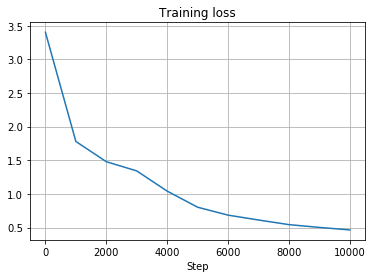

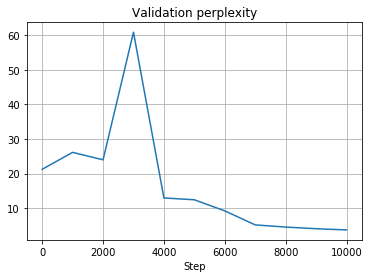

In [68]:
#print (losses)
plt.title('Training loss')
plt.plot(steps, losses)
plt.xlabel("Step")
plt.grid()
plt.show()

#print (valids)
plt.title('Validation perplexity')
plt.plot(steps, valids)
plt.xlabel("Step")
plt.grid()
plt.show()